In [11]:
import pandas as pd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

## Utility Functions

In [126]:
def CAGR(DF):
    df=DF.copy()
    df['cum_return']=(1+df['mon_ret']).cumprod()
    n = len(df)/12
    CAGR = (df['cum_return'].iloc[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    df = DF.copy()
    vol = df['mon_ret'].std()*np.sqrt(12)
    return vol

def sharpe(DF,rf):
    df = DF.copy()
    return (CAGR(df)-rf)/volatility(df)

def max_dd(DF):
    df=DF.copy()
    df['cum_return'] = (1+df['mon_ret']).cumprod()
    df['cum_roll_max'] = df['cum_return'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cum_return']
    return (df['drawdown']/df['cum_roll_max']).max()

## Getting DJI constituent stocks data from 10 years ago


In [128]:
tickers = ["MMM","AXP","T","BA","CAT","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UNH","VZ","V","WMT","DIS"]

In [202]:
# Calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Backtesting

In [190]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

In [191]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

In [192]:
#calculating overall strategy's KPIs
print("CAGR for the portfolio is ",CAGR(pflio(return_df,6,3)))
print("Sharpe Ratio for the portfolio is ",sharpe(pflio(return_df,6,3),0.025))
print("Max Drawdown for the portfolio was ",max_dd(pflio(return_df,6,3))) 

CAGR for the portfolio is  0.12466536640480053
Sharpe Ratio for the portfolio is  0.5837012756796595
Max Drawdown for the portfolio was  0.270127534000104


## Calculating KPIs for index buy and hold startegy for the same period

In [203]:
dji = yf.download("^DJI",start,end, interval = '1mo')
dji['mon_ret']=dji["Adj Close"].pct_change()
print("CAGR for DJI was ",CAGR(dji))
print("Sharpe Ratio for DJI was ",sharpe(dji,0.025))
print("Max Drawdown for DJI was ",max_dd(dji)) 

[*********************100%%**********************]  1 of 1 completed

CAGR for DJI was  0.08678631081475796
Sharpe Ratio for DJI was  0.4050382038508618
Max Drawdown for DJI was  0.23201266165063428


## Visualisation and Results

1 dollar invested in this strategy in 2014 woud be  3.1133320357807808  dollars
1 dollar invested in Dow Jones Index in 2014 woud be  2.2984845771187046  dollars


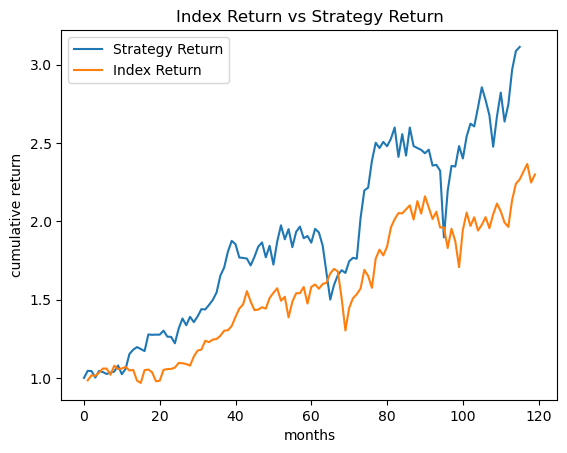

In [216]:
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+dji["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])
print("1 dollar invested in this strategy in 2014 woud be ",(1 + pflio(return_df,6,3)['mon_ret']).cumprod().iloc[-1]," dollars")
print("1 dollar invested in Dow Jones Index in 2014 woud be ",(1 + dji['mon_ret']).cumprod().iloc[-1]," dollars")